In [1]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
import scipy
import ipynb.fs

from ipynb.fs.defs.BCI_COMP_IV_functions import (extractInfo, getFilteredTrials, getTrials, scatter, featureExtraction, createFilterBank,
                                                label_data, psd, plot_psd,testWindowLength, testClassifier, testFrequencyBand,
                                                logvar, plot_logvar, cov, whitening, apply_mix, csp, testWindowStartTime, startRunningClassifier)


In [2]:
dataD = scipy.io.loadmat("BCICIV_1_mat/BCICIV_calib_ds1d.mat")

eeg = dataD["cnt"].T
nChannels, nSamples = eeg.shape

trainData, calibData, W_train, comp = featureExtraction(dataD,0.7)


### Base Classification

In [3]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

ldaModel = LDA()
SVMmodel = SVC()
logRegModel = LogisticRegression()


In [4]:
nCols = len(trainData.columns)

print("LDA: ",np.mean(cross_val_score(ldaModel,trainData.iloc[:,:nCols-2], trainData.iloc[:,nCols-2],cv=5)))
print("Logistic Regression: ",np.mean(cross_val_score(logRegModel,trainData.iloc[:,:nCols-2], trainData.iloc[:,nCols-2],cv=5)))
print("SVM: ",np.mean(cross_val_score(SVMmodel,trainData.iloc[:,:nCols-2], trainData.iloc[:,nCols-2],cv=5)))


LDA:  0.85
Logistic Regression:  0.8571428571428571
SVM:  0.8214285714285714


### Tuned Classification

In [5]:
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

#  Set the parameter grid for grid search
param_grid = {'solver': ['svd', 'lsqr', 'eigen'],'shrinkage': np.arange(0,1,0.1)}

# Create the grid search object
gridLDA = GridSearchCV(estimator=LDA(), param_grid=param_grid,scoring="accuracy", cv=5)

# Fit the grid search to the data
gridLDA.fit(trainData.iloc[:,:nCols-2], trainData.iloc[:,nCols-2])

# Get the best hyperparameters
print(gridLDA.best_params_)

# Get the best score
print(gridLDA.best_score_)


{'shrinkage': 0.0, 'solver': 'lsqr'}
0.85


In [6]:
# Set the parameter grid for grid search
param_grid = {'penalty': ['l1','l2'], 'C':list(np.logspace(-3,3)), 'solver': ['newton-cg', 'lbfgs', 'liblinear']}

# Create the grid search object
gridLogReg = GridSearchCV(estimator=LogisticRegression(), param_grid=param_grid,scoring='accuracy', cv=5)

# Fit the grid search to the data
gridLogReg.fit(trainData.iloc[:,:nCols-2], trainData.iloc[:,nCols-2])

# Get the best hyperparameters
print(gridLogReg.best_params_)

# Get the best score
print(gridLogReg.best_score_)


{'C': 0.1206792640639329, 'penalty': 'l1', 'solver': 'liblinear'}
0.8714285714285716


In [7]:
#Set the parameter grid for grid search

param_grid = {'C': [0.0001,0.001,0.01,1,10,100,1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel':["rbf","linear"]}

# Create the grid search object
gridSVM = GridSearchCV(estimator=SVC(), param_grid=param_grid,scoring="accuracy", cv=5)

# Fit the grid search to the data
gridSVM.fit(trainData.iloc[:,:nCols-2], trainData.iloc[:,nCols-2])

# Get the best hyperparameters
print(gridSVM.best_params_)

# Get the best score
print(gridSVM.best_score_)


{'C': 1000, 'gamma': 0.01, 'kernel': 'rbf'}
0.8714285714285716


### Window Length test

#### Accuracy

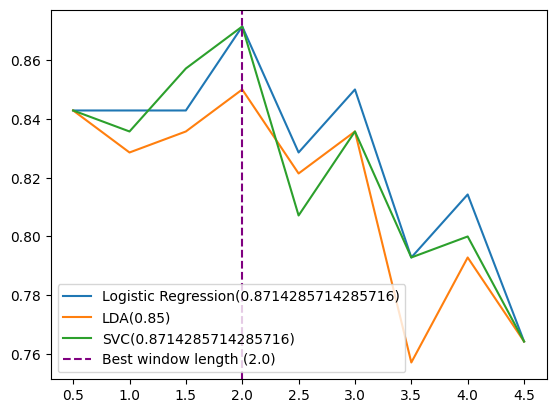

In [8]:

_ = testWindowLength(dataD,
                ["Logistic Regression","LDA","SVC"],
                "accuracy",
                0.7)


### Window Start time test

#### Accuracy

1.1


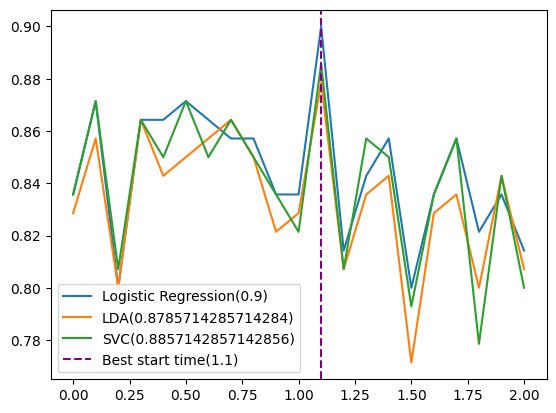

In [9]:
bestEstimator_start_time = testWindowStartTime(dataD,
                    ["Logistic Regression","LDA","SVC"],
                    "accuracy",
                    0.7,
                    2.0)


In [10]:
bestEstimator_start_time


LogisticRegression(C=3.5564803062231287, solver='liblinear')

### Investigating the effect of varying the frquency band 

In [7]:
channelNames,sRate,classLabels,eventOnsets,eventCodes,labels = extractInfo(dataD,nSamples)

filterBank = createFilterBank(sRate)

bestBand, bestEstimator_freq_band, (best_b, best_a) = testFrequencyBand(dataD,["Logistic Regression","LDA","SVC"],filterBank,0.7,trialWinStart=1.1,trialWinEnd=3.1)
bestBand


8-12 : 0.9
8-15 : 0.9928571428571429
13-30 : 0.9857142857142858


(8, 15)

In [8]:
bestEstimator_freq_band

LogisticRegression(C=44.98432668969444, solver='newton-cg')

In [14]:
np.mean(cross_val_score(bestEstimator_freq_band,calibData.iloc[:,:nCols-2], calibData.iloc[:,nCols-2],cv=5))


0.8

### Person's Correlation Coefficient (PCC) + CSP

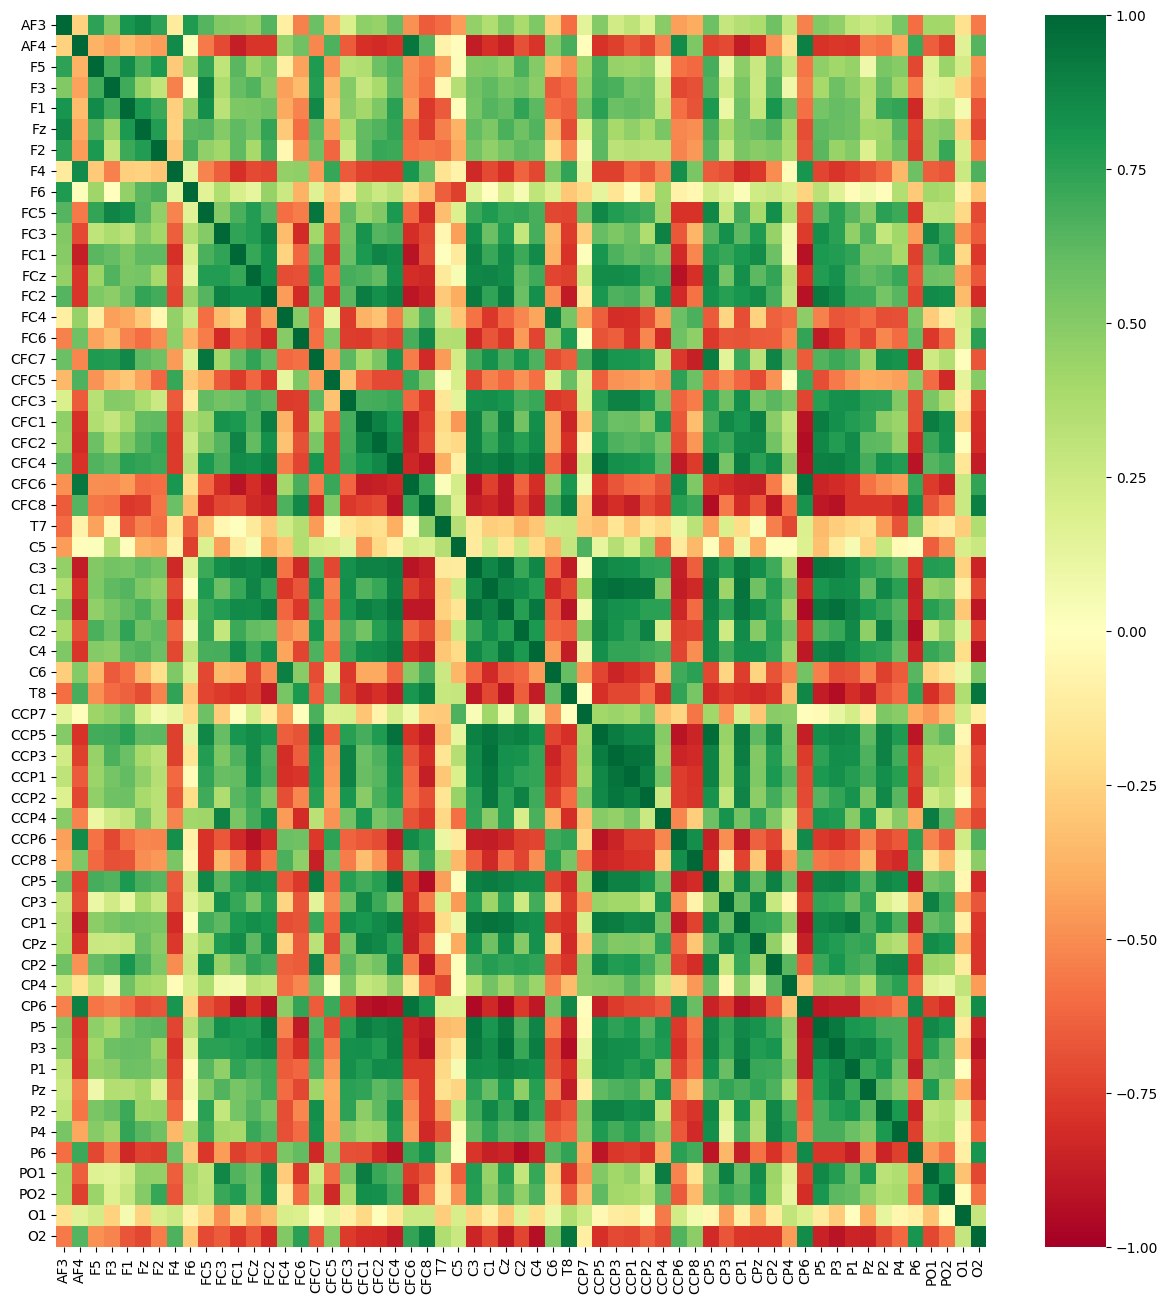

In [12]:
#Plot distributions of channels against eachother
# to find out if there is any sort of positive correlation
# between channels

import seaborn as sns
import pandas as pd
from sklearn.preprocessing import StandardScaler
trialWin = np.arange(int(1.1*sRate),int(3.1*sRate))

# #get mixed trial data from original
trials_mixed = np.zeros(
            (nChannels, len(eventOnsets[0]), len(trialWin)))


for i, onset in enumerate(eventOnsets[0]):
    trials_mixed[:,i,:] = eeg[:,onset+trialWin]

# By augmenting the algorithm outlined in [ref: Electroencephalogram channel selection based on pearson correlation coefficient for motor imagery-brain-computer interface]
# we can able to extract the most correlated channels in the given data prior to selecting features with the CSP algorithm.


scaler = StandardScaler()

# For each trial
#We must standardize the values in each trial window for each channel (We use z-score normalization for this)
_, nTrials, _ = trials_mixed.shape

trialChannelCorrelations = []

plotFirst = False #flag to check that heatmap of first trial is plotted

for trial in range(nTrials):

    zTrial = scaler.fit_transform(trials_mixed[:,trial,:])
    corrMat = np.corrcoef(zTrial)

    if not plotFirst:
        plt.figure(figsize=(15, 16))
        sns.heatmap(pd.DataFrame(corrMat,columns=channelNames,index=channelNames),cmap="RdYlGn",vmin=-1,vmax=1)
        plotFirst = True

#     # We must then calculate the correlation matrices for each trial and return the mean for each row giving, us a vector of mean values
#     # which represents the average corellation values for a specific channel in relation to other channels.
    channelCorrValues = {ch:corrMean for (ch,corrMean) in zip(channelNames,np.mean(corrMat,axis=1))}

#     #Following the above referenced paper, we select the first 14 channels

    channelCorrValues = dict(sorted(channelCorrValues.items(), key=lambda x:x[1], reverse=True)[:14])
    trialChannelCorrelations.append(channelCorrValues)


<AxesSubplot: >

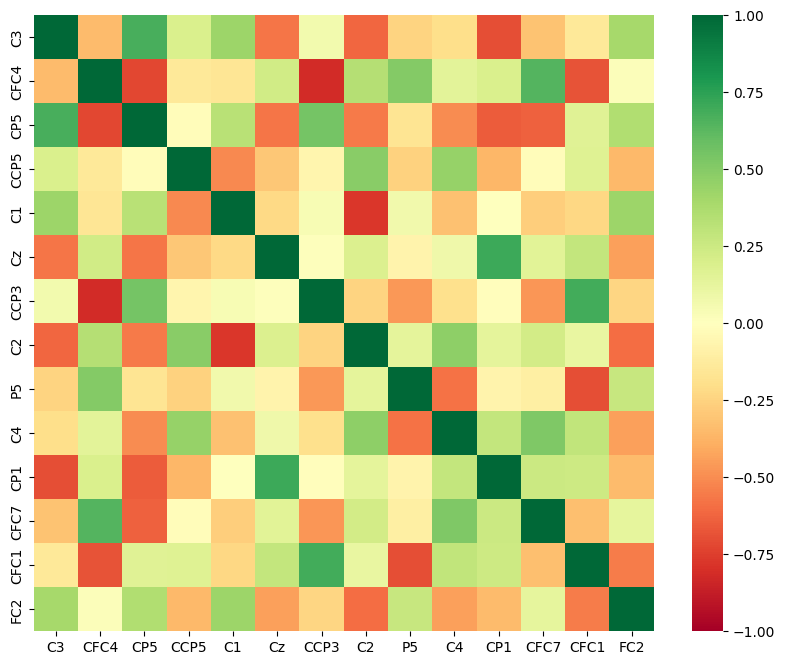

In [13]:
from collections import defaultdict

channelOccurences = defaultdict(int)

for dic in trialChannelCorrelations:
    for ch, _ in dic.items():
        channelOccurences[ch] += 1


channelOccurences = dict(sorted(channelOccurences.items(), key=lambda x:x[1], reverse=True))

selectedChannels = list(channelOccurences.keys())[:14]
# #It can be seen that all selected channels are in and around the sensorimotor cortex

selectedSet = set(selectedChannels)
selectedIdxs = [idx for idx,ch in enumerate(channelNames) if ch in selectedSet]

# #Plot heatmap of first trial
plt.figure(figsize=(10, 8))
sns.heatmap(pd.DataFrame(np.corrcoef(scaler.fit_transform(trials_mixed[selectedIdxs,0,:])),
            columns=selectedChannels,
            index=selectedChannels),
            cmap="RdYlGn",
            vmin=-1,
            vmax=1)


In [9]:
accVal = 0
bestAccVal = 0
bestEstimator_selected_channels = None
for model in ["Logistic Regression","LDA","SVC"]:
    accVal, estimator =  testClassifier(dataD,1.1,3.1,0.7,model,b=best_b,a=best_a,selectedChannels=selectedIdxs)
    print(f"acc val for {model} is {accVal}")
    if accVal > bestAccVal:
        bestAccVal = accVal
        bestEstimator_selected_channels = estimator

bestAccVal


acc val for Logistic Regression is 0.9642857142857144
acc val for LDA is 0.9571428571428571
acc val for SVC is 0.9642857142857142


0.9642857142857144

In [10]:
bestEstimator_selected_channels


LogisticRegression(C=0.03906939937054617, solver='newton-cg')

In [11]:
np.mean(cross_val_score(bestEstimator_selected_channels,calibData.iloc[:,:nCols-2], calibData.iloc[:,nCols-2],cv=5))


0.7833333333333334

### Calibration of best classifier to predict probability outputs for all time samples

In [21]:
from sklearn.calibration import CalibratedClassifierCV

calibrated_estimator = CalibratedClassifierCV(bestEstimator_freq_band, cv="prefit")
calibrated_estimator.fit(calibData.iloc[:,:nCols-2], calibData.iloc[:,nCols-2])

evalDataC = scipy.io.loadmat("BCICIV_1_mat/BCICIV_eval_ds1d.mat")

probabilities = startRunningClassifier(evalDataC,calibrated_estimator,comp,W_train,trialWinStart=1.1,trialWinEnd=3.1,b=best_b,a=best_a)


In [22]:
import csv

with open("output_subject_d.csv", "w") as f:
    wr = csv.writer(f)
    wr.writerows(probabilities)


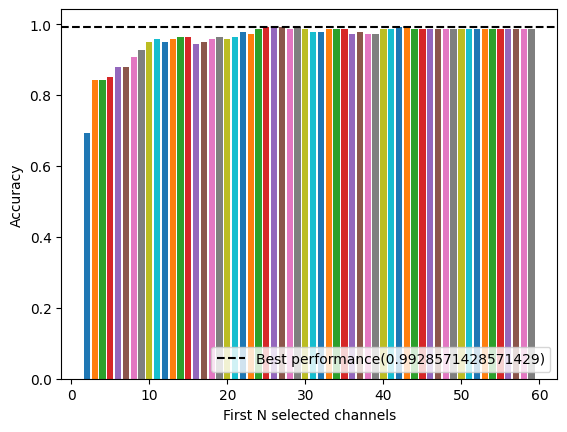

In [14]:
channelNums = dict()

for i in range(2,nChannels+1):
    selectedChannels = list(channelOccurences.keys())[:i]
    # #It can be seen that all selected channels are in and around the sensorimotor cortex

    selectedSet = set(selectedChannels)
    selectedIdxs = [idx for idx,ch in enumerate(channelNames) if ch in selectedSet]

    accVal = 0
    bestAccVal = 0
    bestEstimator_selected_channels = None
    for model in ["Logistic Regression","LDA","SVC"]:
        accVal, estimator =  testClassifier(dataD,1.1,3.1,0.7,model,b=best_b,a=best_a,selectedChannels=selectedIdxs)

        if accVal > bestAccVal:
            bestAccVal = accVal
            bestEstimator_selected_channels = estimator

    channelNums[i] = bestAccVal

bestY = 0
for x, y in channelNums.items():
    bestY= max(bestY,y)
    plt.bar(x,y)

plt.xlabel("First N selected channels")
plt.ylabel("Accuracy")
plt.axhline(y=bestY, color='black', ls='--', lw=1.5, label=f"Best performance({bestY})")
plt.legend(loc='lower right')
